Reinforcement Learning: Assignment 1

Part 1

We start by looking at a simple bandit problem with stationary reward distributions. Consider the so-called k-armed testbed, with k = 10, with normally distributed rewards. Generate a set of ten means μ1,...,μ10 from a N(0,1) distribution and suppose that the arms 1 through 10 have N(μi,1) reward distributions where i = 1,...,10. You goal is to learn the action values corresponding to each of the 10 arms, i.e., the expected rewards q∗(a) for a = 1,...10 using the different methods we discussed fordoing so.

In [498]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt

In [499]:
# Paramaeters
k = 10            # Number of arms in bandit
steps = 10000     # number of steps in an episode
episodes = 1000   # number of episode considered to average reward
mean_type = 1     # 1 = random mean, 2 = same mean for all the episodes, 3 = same mean for each bandit
mean_change = 0   # 0 = no mean change, 1 = drift mean change, 2 = reverting mean change, 3 = abrupt change
Epsilon = 0.1     # For epsilon greedy algorithm
OSV = 2.0         # Optimistic value for optimistic greedy algorithm
Alpha = 0.2       # #alpha=0.2 for gradient bandit algorithm

In [500]:
# Generate random means u with N(0,1)
def random_means():
    return np.random.normal(0, 1, k)

In [501]:
# Generate same starting mean for all the bandits
def fixed_means():
    return np.full(k,np.random.normal(0, 1))

In [502]:
# Generate same starting mean for all the episodes
def same_means():
    np.random.seed(100)
    u=random_means()
    np.random.seed(None)
    return u

In [503]:
# Reward function wuth N(μi,1) reward distributions
def reward_func(u):
    return np.random.normal(u, 1)

In [504]:
# Optimal action check
def optimal_action(action,ui):
    if action==np.argmax(ui):
        return 1.0
    else:
        return 0.0

In [505]:
#drift change of mean
def drift_change(A):
    return A + np.random.normal(0, 0.000001, k)

In [506]:
#reverting change of mean
def reverting_change(A):
    return 0.5*A + np.random.normal(0, 0.000001, k)

In [507]:
#abrupt change of mean
def abrupt_change(A, prob):
    for i in range(len(A)):
        if np.random.rand() < prob:
            swap_idx = np.random.randint(0, len(A))  #identify which element to swap
            A[i], A[swap_idx] = A[swap_idx], A[i]
    return A

In [508]:
# greedy actions with decreasing step size
def greedy(steps, k, u, mean_change):
    Q = np.zeros(k)                #initialize Q table
    N = np.zeros(k)                #initialize action count
    rewards = np.zeros(steps)      #initialize rewards
    oas = np.zeros(steps)          #optimal actions
    ui = u                         #set internal mean value for drift or reverting
    
    for step in range(steps):
        action = np.argmax(Q)       #use max or the next element in array
        reward = reward_func(ui[action])
        oa = optimal_action(action,ui)  #check for optimal action
        if mean_change==1:
            ui = drift_change(ui)           #drift change of mean in every step
        elif mean_change==2:
            ui = reverting_change(ui)           #reverting change of mean in every step
        elif mean_change==3:
            ui = abrupt_change(ui,0.005)           #abrupt change of mean in every step with 0.005 probability
        else:
            ui=ui
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards[step] = reward
        oas[step] = oa
      
    return rewards, oas

In [509]:
# epsilon-greedy actions with with decreasing step size
def epsilon_greedy(steps, k, epsilon, u, mean_change):
    Q = np.zeros(k)                #initialize Q table
    N = np.zeros(k)                #initialize action count
    rewards = np.zeros(steps)      #initialize rewards
    oas = np.zeros(steps)          #optimal actions
    ui = u                         #set internal mean value for drift or reverting
    
    for step in range(steps):
        if np.random.rand() < epsilon: # randomly decide to take greedy action or explore
            action = np.random.choice(k)
        else:
            action = np.argmax(Q)   #use max or the next element in array

        reward =reward_func(ui[action])
        oa =optimal_action(action,ui)  #check for optimal action
        if mean_change==1:
            ui = drift_change(ui)           #drift change of mean in every step
        elif mean_change==2:
            ui = reverting_change(ui)           #reverting change of mean in every step
        elif mean_change==3:
            ui = abrupt_change(ui,0.005)           #abrupt change of mean in every step with 0.005 probability
        else:
            ui=ui
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards[step] = reward
        oas[step] = oa
     
    return rewards, oas

In [510]:
# epsilon-greedy actions with with fixed step size
def epsilon_greedy_FS(steps, k, epsilon, u, mean_change):
    Q = np.zeros(k)                #initialize Q table
    alpha = 0.1                    #Step size
    rewards = np.zeros(steps)      #initialize rewards
    oas = np.zeros(steps)          #optimal actions
    ui = u                         #set internal mean value for drift or reverting
    
    for step in range(steps):
        if np.random.rand() < epsilon: # randomly decide to take greedy action or explore
            action = np.random.choice(k)
        else:
            action = np.argmax(Q)   #use max or the next element in array

        reward =reward_func(ui[action])
        oa =optimal_action(action,ui)  #check for optimal action
        if mean_change==1:
            ui = drift_change(ui)           #drift change of mean in every step
        elif mean_change==2:
            ui = reverting_change(ui)           #reverting change of mean in every step
        elif mean_change==3:
            ui = abrupt_change(ui,0.005)           #abrupt change of mean in every step with 0.005 probability
        else:
            ui=ui
        Q[action] += (reward - Q[action])*alpha
        rewards[step] = reward
        oas[step] = oa
     
    return rewards, oas

In [511]:
# greedy actions with optimistic initial values
def greedy_with_SV(steps, k, ov, u, mean_change):
    # Q = np.full(k,np.mean(u))      #initialize Q table with average of u
    Q = np.full(k,ov)               #initialize Q table with fixed value of 1.2
    N = np.zeros(k)                #initialize action count
    rewards = np.zeros(steps)      #initialize rewards
    oas = np.zeros(steps)          #optimal actions
    ui = u                         #set internal mean value for drift or reverting
    
    for step in range(steps):
        action = np.argmax(Q)       #use max or the next element in array
        reward =reward_func(ui[action])
        oa =optimal_action(action,ui)  #check for optimal action
        if mean_change==1:
            ui = drift_change(ui)           #drift change of mean in every step
        elif mean_change==2:
            ui = reverting_change(ui)           #reverting change of mean in every step
        elif mean_change==3:
            ui = abrupt_change(ui,0.005)           #abrupt change of mean in every step with 0.005 probability
        else:
            ui=ui
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards[step] = reward
        oas[step] = oa
   
    return rewards, oas

In [512]:
# gradient bandit
def gradient_bandit(steps, k, alpha, u, mean_change):
    H = np.zeros(k)               #preference
    Pi = np.zeros(k)              #action probabilities
    rewards = np.zeros(steps)
    oas = np.zeros(steps)          #optimal actions
    average_rewards = 0             #can be set a baseline for improved performance
    ui = u                         #set internal mean value for drift or reverting
    
    for step in range(steps):
        Pi = np.exp(H) / np.sum(np.exp(H))
        action = np.random.choice(k, p=Pi)
        reward = reward_func(ui[action])
        oa =optimal_action(action,ui)  #check for optimal action
        if mean_change==1:
            ui = drift_change(ui)           #drift change of mean in every step
        elif mean_change==2:
            ui = reverting_change(ui)           #reverting change of mean in every step
        elif mean_change==3:
            ui = abrupt_change(ui,0.005)           #abrupt change of mean in every step with 0.005 probability
        else:
            ui=ui
        rewards[step] = reward
        oas[step] = oa
        average_rewards = np.mean(rewards)
        H[action] += alpha * (reward - average_rewards)*(1-Pi[action])
        for i in range(k):
            if i==action:
                pass
            else:
                H[i] -= alpha * (reward - average_rewards) * Pi[i] 
    
    return rewards, oas

In [513]:
# Function to calculate running average
def running_average(arr):
    return np.cumsum(arr) / np.arange(1, len(arr) + 1)

In [514]:
#Run for multiple episodes
reward_array = np.zeros((5,steps))              # reward collection array
action_array = np.zeros((5,steps))              # optimal action collection array
terminal_reward = np.zeros((5,episodes))        # terminal reward initiation

for episode in range(episodes):

    if mean_type==1:
        u=random_means()      # Random mean
    elif mean_type==2:
        u=same_means()        # same mean for each episode
    elif mean_type==3:
        u=fixed_means()       # same mean for each bandit and different for episode to episode
    else:
        u=random_means()      # Random mean

    rd, act = greedy(steps, k, u, mean_change)
    reward_array[0] += rd
    action_array[0] += act
    terminal_reward[0,episode]=rd[-1]                                #collect last reward of the episode in algorithm 1
    rd, act = epsilon_greedy(steps, k, Epsilon, u, mean_change)          #epsilon=0.1 from evaluation
    reward_array[1] += rd
    action_array[1] += act
    terminal_reward[1,episode]=rd[-1]                                #collect last reward of the episode in algorithm 2
    rd, act = greedy_with_SV(steps, k, OSV, u, mean_change)          #Optimistic value set to 2.0 
    reward_array[2] += rd
    action_array[2] += act
    terminal_reward[2,episode]=rd[-1]                                #collect last reward of the episode in algorithm 3
    rd, act = gradient_bandit(steps, k, Alpha, u, mean_change)         #alpha=0.2 from evaluvation
    reward_array[3] += rd
    action_array[3] += act
    terminal_reward[3,episode]=rd[-1]                                #collect last reward of the episode in algorithm 4
    rd, act = epsilon_greedy_FS(steps, k, Epsilon, u, mean_change)       #epsilon=0.1 from evaluation
    reward_array[4] += rd
    action_array[4] += act
    terminal_reward[4,episode]=rd[-1] 


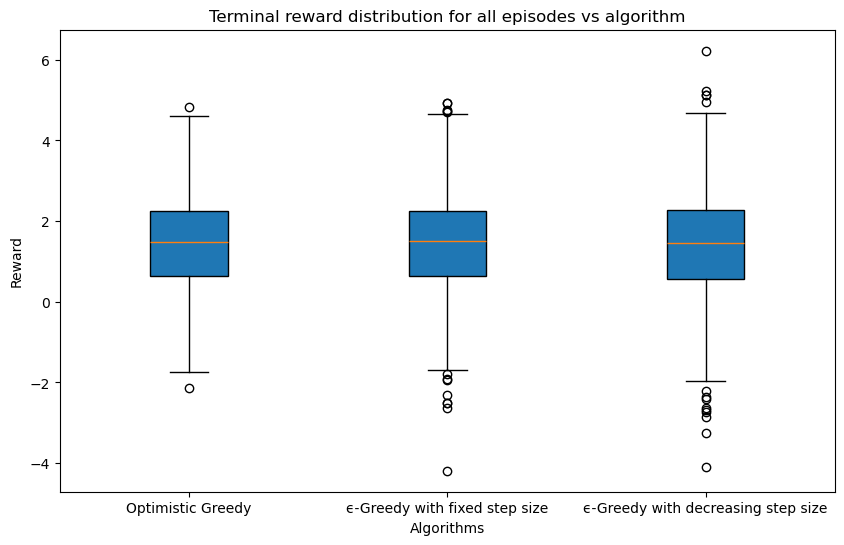

[1.45534563 1.42446225 1.3937875 ]


In [515]:
#Box plot with terminal rewards
data=terminal_reward[[2, 4, 1]] #extracted only the 3,5 and 2 data set
plt.figure(figsize=(10, 6))
plt.boxplot(data.T, vert=True, patch_artist=True, showmeans=False)
plt.title('Terminal reward distribution for all episodes vs algorithm')
plt.xlabel('Algorithms')
plt.ylabel('Reward')
plt.xticks([1,2,3], ['Optimistic Greedy', 'ϵ-Greedy with fixed step size','ϵ-Greedy with decreasing step size' ])
plt.show()

print(np.mean(data,axis=1))

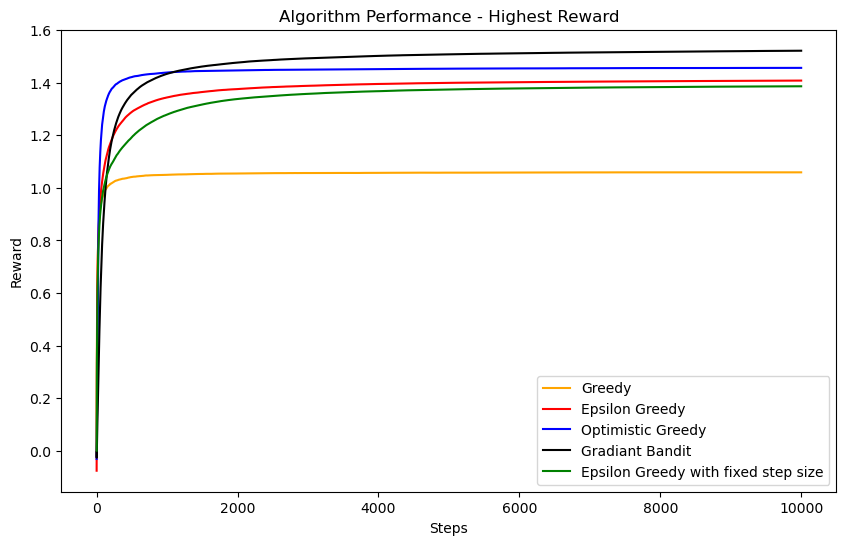

In [516]:
# Calculate the running average
running_avg1 = running_average(reward_array[0]/episodes)
running_avg2 = running_average(reward_array[1]/episodes)
running_avg3 = running_average(reward_array[2]/episodes)
running_avg4 = running_average(reward_array[3]/episodes)
running_avg5 = running_average(reward_array[4]/episodes)

# Plot the original array and the running average
plt.figure(figsize=(10, 6))
plt.plot(running_avg1, label='Greedy', color='orange')
plt.plot(running_avg2, label='Epsilon Greedy', color='red')
plt.plot(running_avg3, label='Optimistic Greedy', color='blue')
plt.plot(running_avg4, label='Gradiant Bandit', color='black')
plt.plot(running_avg5, label='Epsilon Greedy with fixed step size', color='green')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Algorithm Performance - Highest Reward')
plt.legend()
plt.show()

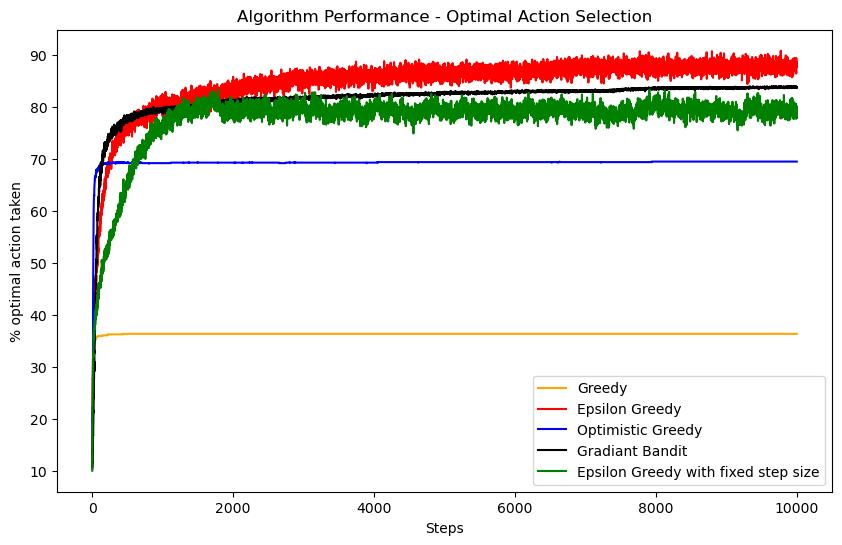

In [517]:
# Plot optimal action taken or not at each steps with all the episodes
plt.figure(figsize=(10, 6))
plt.plot(action_array[0]/episodes*100, label='Greedy', color='orange')
plt.plot(action_array[1]/episodes*100, label='Epsilon Greedy', color='red')
plt.plot(action_array[2]/episodes*100, label='Optimistic Greedy', color='blue')
plt.plot(action_array[3]/episodes*100, label='Gradiant Bandit', color='black')
plt.plot(action_array[4]/episodes*100, label='Epsilon Greedy with fixed step size', color='green')
plt.xlabel('Steps')
plt.ylabel('% optimal action taken')
plt.title('Algorithm Performance - Optimal Action Selection')
plt.legend()
plt.show()